In [1]:
# SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom, hypergeom

import warnings
warnings.filterwarnings('ignore')

**OBS**

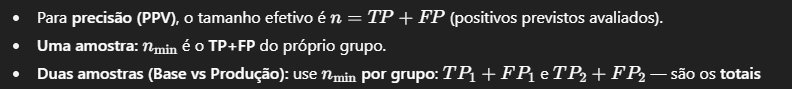

# 1. Uma proporção com aproximação normal.

In [2]:
def decision1(p_value, diff_obs, n_obs, n_min, alpha=0.05, MDE=0.05):
    """
    Fluxo de decisão para avaliar degradação.

    Parâmetros
    ----------
    p_value : float
        Valor-p do teste (já calculado).
    diff_obs : float
        Diferença observada (p_exp - p_obs).
    n_obs : int
        Tamanho da amostra observada.
    n_min : int
        Tamanho mínimo da amostra necessário para detectar MDE.
    alpha : float, opcional
        Nível de significância (default=0.05).
    MDE : float, opcional
        Mínimo efeito detectável (default=0.05).

    Retorna
    -------
    str : decisão final
    """

    if p_value <= alpha:
        if diff_obs >= MDE:
            return "Degradação relevante"
        else:
            return "Degradação irrelevante"
    else:
        if n_obs >= n_min:
            return "Não há evidência de degradação"
        else:
            return "Inconclusivo (amostra insuficiente)"
        
def decision2(p_value, diff_obs, n_base, n_obs, n_min, alpha=0.05, MDE=0.05):
    """
    Fluxo de decisão para avaliar degradação (teste unicaudal para queda).

    Parâmetros
    ----------
    p_value : float
        Valor-p do teste (já calculado).
    diff_obs : float
        Diferença observada (p_exp - p_obs).
    n_base : int
        Tamanho da amostra do baseline.
    n_obs : int
        Tamanho da amostra da produção/observado.
    n_min : int
        Tamanho mínimo por grupo necessário para detectar a MDE (planejado).
    alpha : float, opcional
        Nível de significância (default=0.05).
    MDE : float, opcional
        Mínimo efeito detectável (default=0.05).

    Retorna
    -------
    str : decisão final
    """
    n_eff = min(n_base, n_obs)  # efetivo para checar suficiência amostral

    if p_value <= alpha:
        if diff_obs >= MDE:
            return "Degradação relevante"
        else:
            return "Degradação irrelevante"
    else:
        if n_eff >= n_min:
            return "Não há evidência de degradação"
        else:
            return "Inconclusivo (amostra insuficiente)"


## Significância:

In [3]:
# Inputs
p_exp = 0.90 # Valor esperado
p_obs = 0.88 # Veio da amostra fornecida
n_obs = 300  # Veio da amostra fornecida
MDE   = 0.05 # Definição do business
alpha = 0.05 # Definição técninca
beta  = 0.20 # Definição técninca

**Normal:**

In [4]:
# H0: p = p0: O valor observado provém do acaso da amostragem, e não temos evidência para rejeitar H0 em favor de H1.
# H1: p < p0: De fato a proporção em produção é inferior ao esperado.

# Distribuição sob H0:
p0 = p_exp
n  = n_obs

## Requisitos para aproximação normal
print(f"Pode aproximar pela normal: {(n*p0 >= 10) and (n*(1-p0) >= 10)}") 

## Padronizando o valor observado
SE0   = np.sqrt(p0*(1-p0)/n)
Z_obs = (p_obs - p0)/SE0
print(f"Z_obs = {np.round(Z_obs, 2)}")

## Calculando p_value (probabilidade do acaso gerar um valor menor ou igual ao observado)
p_value = norm.cdf(Z_obs)

## Decisão
if p_value <= alpha:
    print(f"p-valor = {p_value:.4f} ≤ α = {alpha} → Rejeitamos H0")
else:
    print(f"p-valor = {p_value:.4f} > α = {alpha} → Não rejeitamos H0")

Pode aproximar pela normal: True
Z_obs = -1.15
p-valor = 0.1241 > α = 0.05 → Não rejeitamos H0


## Poder do Teste:

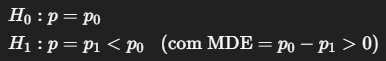

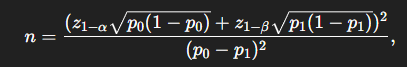

In [5]:
p1        = p0 - MDE
Z_1_alpha = norm.ppf(1-alpha)
Z_1_beta  = norm.ppf(1-beta)
n_min     = int(np.ceil(((Z_1_alpha*np.sqrt(p0*(1-p0)) + Z_1_beta*np.sqrt(p1*(1-p1)))**2)/((p0-p1)**2)))
print(f"""
>>>> Para detectar uma diferença mínima de {int(np.round(MDE*100,0))}p.p. em {int((1-beta)*100)}% das vezes que de fato ela existir.
>>>> Sob o risco de dizer que essa diferença ocorre em no máximo {int((alpha)*100)}% dos casos onde de fato ela não existe.
>>>> Precisamos de um n_min = {n_min}.
""")


>>>> Para detectar uma diferença mínima de 5p.p. em 80% das vezes que de fato ela existir.
>>>> Sob o risco de dizer que essa diferença ocorre em no máximo 5% dos casos onde de fato ela não existe.
>>>> Precisamos de um n_min = 253.



## Decisão

In [6]:
diff_obs = np.round(p_exp - p_obs,2)
decision1(p_value, diff_obs, n_obs, n_min, alpha, MDE)

'Não há evidência de degradação'

# 2. Uma proporção sem aproximação normal.

## Significância:

In [7]:
# Inputs
p_exp = 0.90 # Valor esperado
p_obs = 0.88 # Veio da amostra fornecida
n_obs = 50   # Veio da amostra fornecida
MDE   = 0.05 # Definição do business
alpha = 0.05 # Definição técninca
beta  = 0.20 # Definição técninca

**Binomial Exato:**
- Suponha que coletamos uma amostra de tamanho **n**, na qual a probabilidade de obter sucesso em cada observação é sempre **p**.
- Se repetirmos esse experimento infinitas vezes, o número de sucessos em cada repetição seguirá uma distribuição binomial, que nos fornece as probabilidades de observar diferentes quantidades de sucessos em n tentativas.

In [8]:
# H0: p = p0: O valor observado provém do acaso da amostragem, e não temos evidência para rejeitar H0 em favor de H1.
# H1: p < p0: De fato a proporção em produção é inferior ao esperado.

# Distribuição sob H0:
p0 = p_exp
n  = n_obs
x  = binom(n, p0) # p = x/n

## número de sucessos observados, equivalente a p_obs:
x_obs = round(n * p_obs)

## Prbabilidade de observar um número de sucessos menor ou igual ao observado em n tentativas, somente pelo efeito do acaso.
p_value = binom.cdf(x_obs, n, p0)

## Decisão
if p_value <= alpha:
    print(f"p-valor = {p_value:.4f} ≤ α = {alpha} → Rejeitamos H0")
else:
    print(f"p-valor = {p_value:.4f} > α = {alpha} → Não rejeitamos H0")

p-valor = 0.3839 > α = 0.05 → Não rejeitamos H0


## Poder do Teste:

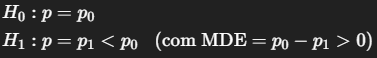

In [9]:
n = 0
while True:
    n +=1

    # Distribuição sob H0:
    dist_h0  = binom(n, p0) # x sucessos sob H0

    # Distribuição sob H1:
    dist_h1 = binom(n, p1) # x sucessos sob H1

    # Queremos c que satisfaça: 
    ## 1) P_H0(X <= c) <= alpha
    c = int(dist_h0.ppf(alpha))        # | P(X ≤ k) ≥ alpha
    while dist_h0.cdf(c) > alpha: c-=1 # Ajuste para não violar alpha

    ## 2) P_H1(X <= c) >= 1 - beta
    if dist_h1.cdf(c) >= 1 - beta:
        print(f"n_min = {n}")
        #print(f"c = {c}")
        #print(f"alpha_real = {dist_h0.cdf(c)}")
        #print(f"poder_real = {dist_h1.cdf(c)}")
        n_min = n
        break

print(f"""
>>>> Para detectar uma diferença mínima de {int(np.round(MDE*100,0))}p.p. em {int((1-beta)*100)}% das vezes que de fato ela existir.
>>>> Sob o risco de dizer que essa diferença ocorre em no máximo {int((alpha)*100)}% dos casos onde de fato ela não existe.
>>>> Precisamos de um n_min = {n_min}.
""")

n_min = 270

>>>> Para detectar uma diferença mínima de 5p.p. em 80% das vezes que de fato ela existir.
>>>> Sob o risco de dizer que essa diferença ocorre em no máximo 5% dos casos onde de fato ela não existe.
>>>> Precisamos de um n_min = 270.



## Decisão

In [10]:
diff_obs = np.round(p_exp - p_obs,2)
decision1(p_value, diff_obs, n_obs, n_min, alpha, MDE)

'Inconclusivo (amostra insuficiente)'

# 3. Duas proporções com aproximação normal.

## Significância:

In [11]:
# Inputs
p_base = 0.94 # Veio da amostra fornecida
n_base = 400  # Veio da amostra fornecida
p_obs  = 0.89 # Veio da amostra fornecida
n_obs  = 400  # Veio da amostra fornecida
MDE    = 0.05 # Definição do business
alpha  = 0.05 # Definição técninca
beta   = 0.20 # Definição técninca

**Normal:**

In [12]:
# A: baseline
# B: produção
# H0: pA - pB = 0: O valor observado provém do acaso da amostragem, e não temos evidência para rejeitar H0 em favor de H1.
# H1: pA - pB > 0: De fato a proporção em produção é inferior ao baseline.

# Distribuição sob H0:
nA = n_base
nB = n_obs
p0 = (nA*p_base + nB*p_obs)/(nA + nB) # pooled amostral

## Requisitos para aproximação normal
print(f"Pode aproximar pela normal: {(nA*p0 >= 10) and (nA*(1-p0) >= 10)}") 
print(f"Pode aproximar pela normal: {(nB*p0 >= 10) and (nB*(1-p0) >= 10)}") 

## Padronizando o valor observado
SE0      = np.sqrt(p0*(1-p0)/nA + p0*(1-p0)/nB)
diff_obs = p_base - p_obs
Z_obs    = diff_obs/SE0
print(f"Z_obs = {np.round(Z_obs, 2)}")

## Calculando p_value (probabilidade do acaso gerar uma diferença maior ou igual ao observado)
p_value = 1 - norm.cdf(Z_obs)

## Decisão
if p_value <= alpha:
    print(f"p-valor = {p_value:.4f} ≤ α = {alpha} → Rejeitamos H0")
else:
    print(f"p-valor = {p_value:.4f} > α = {alpha} → Não rejeitamos H0")

Pode aproximar pela normal: True
Pode aproximar pela normal: True
Z_obs = 2.54
p-valor = 0.0056 ≤ α = 0.05 → Rejeitamos H0


## Poder do Teste:

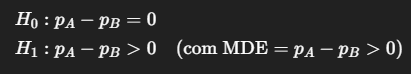

In [13]:
pA        = p_base            # Valor esperado do Baseline (0,5 - Extremo | histórico, piloto)
pB        = pA - MDE          # Observado sob o efeito mínimo detectável
p0        = (pA + pB)/2       # Média (não é o pooled observado)

Z_1_alpha = norm.ppf(1-alpha) # Sob H0: Rejeita H0 quando -> P_ho(diff >= c) <= alpha -> Z >= Z_1_alpha
Z_1_beta  = norm.ppf(1-beta)  # Sob H1: Poder do teste    -> P_h1(diff >= c) >= 1- beta -> Z >= Z_beta
n_min     = ((Z_1_alpha * np.sqrt(2*p0*(1-p0)) + Z_1_beta * np.sqrt((pA*(1-pA) + pB*(1-pB)))) / (pA - pB)) ** 2
n_min     = int(np.ceil(n_min))

print(f"""
>>>> Para detectar uma diferença mínima de {int(np.round(MDE*100,0))}p.p. em {int((1-beta)*100)}% das vezes que de fato ela existir.
>>>> Sob o risco de dizer que essa diferença ocorre em no máximo {int((alpha)*100)}% dos casos onde de fato ela não existe.
>>>> Precisamos de um n_min = {n_min} por grupo.
""")



>>>> Para detectar uma diferença mínima de 5p.p. em 80% das vezes que de fato ela existir.
>>>> Sob o risco de dizer que essa diferença ocorre em no máximo 5% dos casos onde de fato ela não existe.
>>>> Precisamos de um n_min = 384 por grupo.



## Decisão

In [14]:
diff_obs = np.round(p_base - p_obs,2)
decision2(p_value, diff_obs, n_base, n_obs, n_min, alpha, MDE)

'Degradação relevante'

# 4. Duas proporções sem aproximação normal.

## Significância:

In [15]:
# Inputs
p_base = 0.94 # Veio da amostra fornecida
n_base = 400  # Veio da amostra fornecida
p_obs  = 0.89 # Veio da amostra fornecida
n_obs  = 400  # Veio da amostra fornecida
MDE    = 0.05 # Definição do business
alpha  = 0.05 # Definição técninca
beta   = 0.20 # Definição técninca

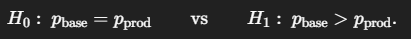

**Teste Exato de Fisher**

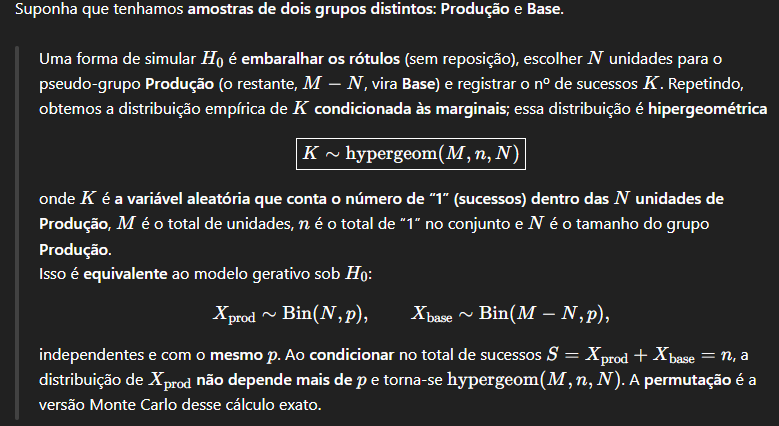

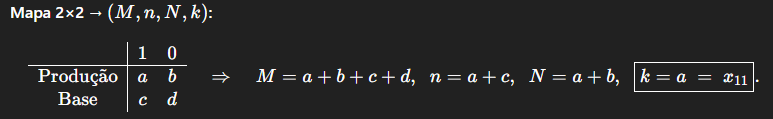

In [16]:
# Garantir consistência
x_obs  = int(round(p_obs  * n_obs))  # Somente valor inteiro
x_base = int(round(p_base * n_base)) # Somente valor inteiro
x_obs  = min(max(0, x_obs),  n_obs)  # 0 <= x_obs <= n_obs
x_base = min(max(0, x_base), n_base) # 0 <= x_base <= n_base

# Distribuição sob H0:

## Marginais fixas:
M = n_obs + n_base     # Tamanho da população (finita)
N = n_obs              # Tamanho da amostra coletada aleatoriamente para compor o grupo de interesse
n = x_obs + x_base     # Quantidade de ocorrências do atributo de interesse na população
K = hypergeom(M, n, N) # Distribuição do número de sucessos obtidos em cada amostragem aleatoria de tamanho N a partir da população M, supondo que não há diferença entre os grupos.

k_min = max(0, N - (M - n))  # mínimo de “1” possível = max(0, amostra - nº de zeros disponíveis)
k_max = min(N, n)            # máximo de “1” possível = min(tamanho da amostra, total de “1” na população)
assert k_min <= x_obs <= k_max


## p_value = P(K <= x_obs): (probabilidade do acaso gerar um k menor ou igual ao k_obs)
p_value_less = K.cdf(x_obs)

## p_value = P(K > x_obs)  +  P(K = x_obs): (probabilidade do acaso gerar um k maior ou igual ao k_obs)
p_value_greater = K.sf(x_obs - 1)

## p_value = pmf[pmf(x_obs) <= pmf(k)].sum(): Bicaudal, probabilidade do acaso gerar uma tabela tão improvável quanto à observada.
pmfs        = K.pmf(np.arange(k_min, k_max + 1))
pmf_obs     = K.pmf(x_obs)
p_value_two = pmfs[pmfs <= pmf_obs].sum()

## Decisão
p_value = p_value_less
if p_value <= alpha:
    print(f"p-valor = {p_value:.4f} ≤ α = {alpha} → Rejeitamos H0")
else:
    print(f"p-valor = {p_value:.4f} > α = {alpha} → Não rejeitamos H0")

p-valor = 0.0077 ≤ α = 0.05 → Rejeitamos H0


## Poder do Teste:

In [17]:
REP   = 100_000
pA    = p_base            # Valor esperado do Baseline (0,5 - Extremo | histórico, piloto)
pB    = pA - MDE          # Observado sob o efeito mínimo detectável
n_min = 1
power = 0

while power < 1 - beta:

    # Distribuição sob H1:
    x_base  = binom.rvs(n_min, pA, size = REP) # Sucesso observados
    x_obs  = binom.rvs(n_min, pB, size = REP)  # Sucesso observados
    n_obs = n_base = n_min

    # Relizando o mesmo procedimento do teste de hipótese, mas sabendo que as amostras provém de populações distintas:
    #------>
    ## Marginais fixas:
    M = n_obs + n_base     # Tamanho da população (finita)
    N = n_obs              # Tamanho da amostra coletada aleatoriamente para compor o grupo de interesse
    n = x_obs + x_base     # Quantidade de ocorrências do atributo de interesse na população
    K = hypergeom(M, n, N) # Distribuição do número de sucessos obtidos em cada amostragem aleatoria de tamanho N a partir da população M, supondo que não há diferença entre os grupos.

    ## p_value = P(K <= x_obs): (probabilidade do acaso gerar um k menor ou igual ao k_obs)
    p_value_less = K.cdf(x_obs)
    #------>
    
    # power = 1 - beta, proporção de vezes que o H0 foi rejeitado, sendo que de fato é falso
    power = (p_value_less <= alpha).mean()

    # incremento
    n_min += 1

In [18]:
print(f"""
>>>> Para detectar uma diferença mínima de {int(np.round(MDE*100,0))}p.p. em {int((1-beta)*100)}% das vezes que de fato ela existir.
>>>> Sob o risco de dizer que essa diferença ocorre em no máximo {int((alpha)*100)}% dos casos onde de fato ela não existe.
>>>> Precisamos de um n_min = {n_min} por grupo.
""")


>>>> Para detectar uma diferença mínima de 5p.p. em 80% das vezes que de fato ela existir.
>>>> Sob o risco de dizer que essa diferença ocorre em no máximo 5% dos casos onde de fato ela não existe.
>>>> Precisamos de um n_min = 416 por grupo.



## Decisão

In [19]:
diff_obs = np.round(p_base - p_obs,2)
decision2(p_value, diff_obs, n_base, n_obs, n_min, alpha, MDE)

'Degradação relevante'